In [166]:
import os
import numpy as np
import pandas as pd
import cv2 
import matplotlib.pyplot as plt

rng = np.random.default_rng()

In [113]:
train = pd.read_csv('train.csv')
train.head()

,filename,x1,y1,x2,y2,x3,y3,x4,y4,x5,...,x10,y10,x11,y11,x12,y12,x13,y13,x14,y14
0,05317.jpg,25,55,63,39,145,36,171,45,39,...,159,65,113,103,79,148,113,148,143,141
1,04767.jpg,17,32,39,27,56,22,81,16,20,...,86,28,56,66,45,80,59,80,74,76
2,05241.jpg,33,44,70,44,119,41,142,41,33,...,144,56,94,101,74,135,89,135,112,133
3,03849.jpg,96,157,222,143,389,129,517,125,153,...,467,188,328,339,241,451,335,453,419,441
4,00952.jpg,13,19,30,16,51,17,66,16,18,...,59,23,39,43,31,56,41,56,49,55


## Посмотрим на имеющиеся изображения

In [4]:
img = cv2.imread('train/04767.jpg')
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
keypoints = train.loc[train['filename'] == '04767.jpg'].values[0][1:]

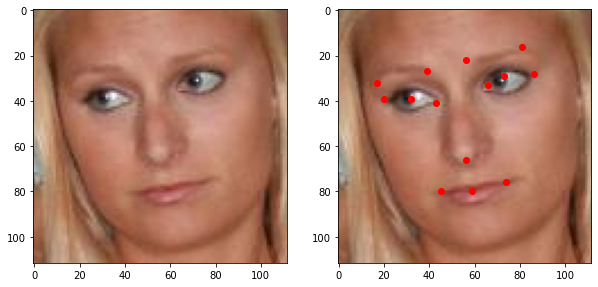

In [11]:
fig, (ax1, ax2) = plt.subplots(1, 2)
fig.set_size_inches(10,8)
ax1.imshow(img)
ax2.imshow(img)
ax2.scatter(x=keypoints[::2], y=keypoints[1::2], color='r')

In [8]:
train.isna().any().any() # пропущенных значений в ключевых точках нет

False

In [179]:
def get_raw_images_df(dirname):
    raw_img = []
    for filename in os.listdir(dirname):
        img = cv2.imread(os.path.join(dirname, filename))
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        raw_img.append([filename, img, img.shape[0]])
    raw_img = pd.DataFrame(raw_img, columns=['filename','raw_img','size'])
    return raw_img

In [180]:
raw_img = get_raw_images_df('train')

error: OpenCV(4.6.0) D:\a\opencv-python\opencv-python\opencv\modules\core\src\alloc.cpp:73: error: (-4:Insufficient memory) Failed to allocate 12060075 bytes in function 'cv::OutOfMemoryError'


In [ ]:
train_img = train.merge(raw_img, on='filename')

In [75]:
train_img.head()

,filename,x1,y1,x2,y2,x3,y3,x4,y4,x5,...,x11,y11,x12,y12,x13,y13,x14,y14,raw_img,size
0,05317.jpg,25,55,63,39,145,36,171,45,39,...,113,103,79,148,113,148,143,141,"[[[198, 198, 198], [208, 208, 208], [208, 208,...",215
1,04767.jpg,17,32,39,27,56,22,81,16,20,...,56,66,45,80,59,80,74,76,"[[[90, 113, 139], [88, 111, 137], [93, 117, 14...",112
2,05241.jpg,33,44,70,44,119,41,142,41,33,...,94,101,74,135,89,135,112,133,"[[[53, 51, 51], [31, 27, 26], [74, 71, 63], [1...",195
3,03849.jpg,96,157,222,143,389,129,517,125,153,...,328,339,241,451,335,453,419,441,"[[[147, 147, 147], [146, 146, 146], [146, 146,...",645
4,00952.jpg,13,19,30,16,51,17,66,16,18,...,39,43,31,56,41,56,49,55,"[[[20, 14, 31], [0, 0, 8], [3, 5, 13], [3, 8, ...",80


## Data Augmentation

Сначала хотела использовать `ImageDataGenerator`, но потом прочитала, что он deprecated и вместо него следует использовать `keras preprocessing_layers`, и там есть разные слои для аугментации данных.

![](keras_aug.png)

Но такие модификации как сдвиги, повороты, отражения и тд сдвигают и ключевые точки. Такие модификации, думаю, лучше прописать самостоятельно, а, например RandomContrast и тому подобные можно будет использовать, так как на координаты они не повлияют.

In [163]:
NEW_SIZE = 170
keypoint_cols = ['x' + str(i+1) for i in range(14)] + ['y' + str(i+1) for i in range(14)]

def resize_img_and_keypoints(data, new_size):
    df = data.copy()
    
    df['raw_img'] = df['raw_img'].apply(lambda x: cv2.resize(x, (new_size, new_size)))
    scale = new_size/df['size']
    for col in keypoint_cols:
        if col.startswith('x'):
            df[col] -= df['size']/2
        if col.startswith('y'):
            df[col] = df['size']/2 - df[col] 
        
        df[col] *= scale
        
        if col.startswith('x'):
            df[col] += new_size/2
        if col.startswith('y'):
            df[col] = new_size/2 - df[col] 
        df[col] = np.round(df[col],2)
        
    
    return df


In [164]:
train_resized = resize_img_and_keypoints(train_img, NEW_SIZE)
# сейчас выбрала размер 170х170 пикселей как медианный среди изображений в датасете
# в дальнейшем можно будет поэскпериментировать с размером входных изображений и найти оптимальный для обучения

In [165]:
train_resized[keypoint_cols].head()

,x1,x2,x3,x4,x5,x6,x7,x8,x9,x10,...,y5,y6,y7,y8,y9,y10,y11,y12,y13,y14
0,19.77,49.81,114.65,135.21,30.84,48.23,62.47,102.79,114.65,125.72,...,58.51,54.56,56.93,53.77,51.40,51.40,81.44,117.02,117.02,111.49
1,25.80,59.20,85.00,122.95,30.36,48.57,65.27,100.18,110.80,130.54,...,59.20,59.20,62.23,50.09,44.02,42.50,100.18,121.43,121.43,115.36
2,28.77,61.03,103.74,123.79,28.77,43.59,60.15,110.72,121.18,125.54,...,61.90,57.54,57.54,50.56,48.82,48.82,88.05,117.69,117.69,115.95
3,25.30,58.51,102.53,136.26,40.33,53.50,65.63,100.16,112.02,123.09,...,55.35,52.19,55.35,51.66,47.71,49.55,89.35,118.87,119.40,116.23
4,27.62,63.75,108.38,140.25,38.25,51.00,61.62,102.00,116.88,125.38,...,53.12,53.12,53.12,55.25,51.00,48.88,91.38,119.00,119.00,116.88


Text(0.5, 1.0, 'Приведенное к единому размеру с точками')

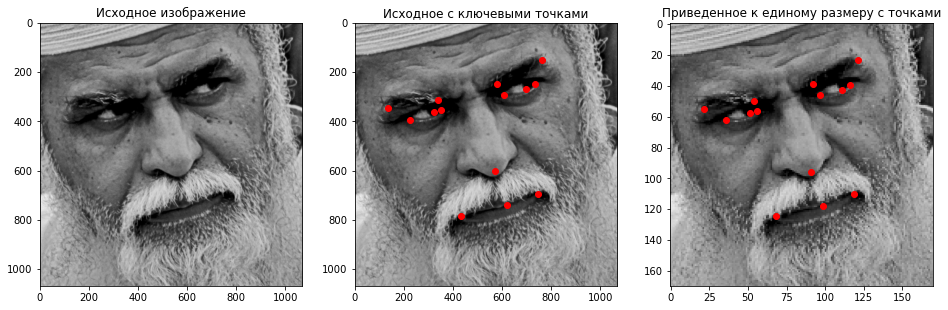

In [157]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3)
fig.set_size_inches(16,9)
ax1.imshow(train_img.iloc[10]['raw_img'])
ax2.imshow(train_img.iloc[10]['raw_img'])
ax2.scatter(x=train_img.iloc[10][keypoint_cols[:14]], y=train_img.iloc[10][keypoint_cols[14:]], color='r')
ax3.imshow(train_resized.iloc[10]['raw_img'])
ax3.scatter(x=train_resized.iloc[10][keypoint_cols[:14]], y=train_resized.iloc[10][keypoint_cols[14:]], color='r')

ax1.set_title('Исходное изображение')
ax2.set_title('Исходное с ключевыми точками')
ax3.set_title('Приведенное к единому размеру с точками');

Теперь все изображения в тестовом датасете приведены к единому размеру. Добавим некоторые функции, которые будут изменять имеющиеся данные и тем самым расширять датасет.

In [194]:
def flip(data, fraction=0.3):
    
    df = data.sample(frac=fraction, replace=False)
    
    flip_type = rng.integers(1)
    df['raw_img'] = df['raw_img'].apply(lambda x: cv2.flip(x, flip_type))
    if flip_type == 0:
        #vertical flip
        for col in keypoint_cols[14:]:
            df[col] = NEW_SIZE - df[col]
            
    elif flip_type == 1:
        #horizontal flip
        for col in keypoint_cols[:14]:
            df[col] = NEW_SIZE - df[col]

    return df

In [195]:
flipped_img = flip(train_resized, fraction=0.1)

Text(0.5, 1.0, 'Отраженное с ключевыми точками')

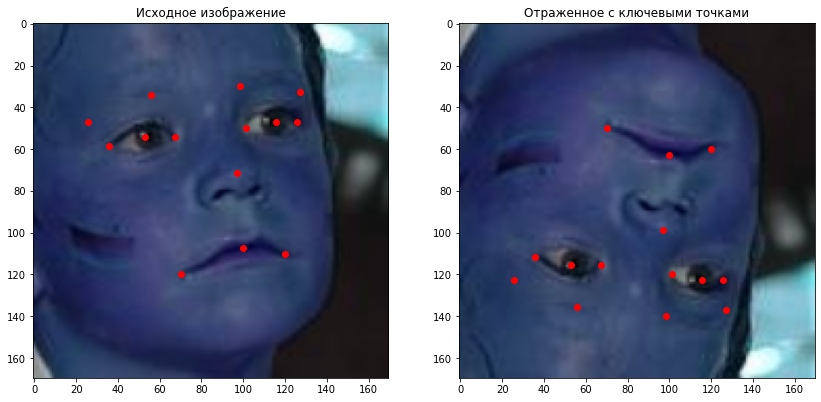

In [201]:
fig, (ax1, ax2) = plt.subplots(1, 2)
fig.set_size_inches(14,8)
ax2.imshow(flipped_img.iloc[0]['raw_img'])
ax2.scatter(x=flipped_img.iloc[0][keypoint_cols[:14]], y=flipped_img.iloc[0][keypoint_cols[14:]], color='r')
ind = flipped_img.index[0]
ax1.imshow(train_resized.loc[ind]['raw_img'])
ax1.scatter(x=train_resized.loc[ind][keypoint_cols[:14]], y=train_resized.loc[ind][keypoint_cols[14:]], color='r')

ax1.set_title('Исходное изображение')
ax2.set_title('Отраженное с ключевыми точками')

In [184]:
flipped_img[flipped_img['filename'] == '00310.jpg']['raw_img']

3642    [[[113, 115, 116], [113, 115, 116], [112, 114,...
Name: raw_img, dtype: object

In [ ]:
def rotate(data, fraction):
    df = data.sample(frac=fraction, replace=False)
    
    flip_type = rng.integers(1)
    df['raw_img'] = df['raw_img'].apply(lambda x: cv2.flip(x, flip_type))
    if flip_type == 0:
        #vertical flip
        for col in keypoint_cols[14:]:
            df[col] = NEW_SIZE - df[col]
            
    elif flip_type == 1:
        #horizontal flip
        for col in keypoint_cols[:14]:
            df[col] = NEW_SIZE - df[col]

    return df
    image, angle
    image_center = tuple(np.array(image.shape[1::-1]) / 2)
    rot_mat = cv2.getRotationMatrix2D(image_center, angle, 1.0)
    result = cv2.warpAffine(image, rot_mat, image.shape[1::-1], flags=cv2.INTER_LINEAR)
    return result